In [38]:
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import model_selection,metrics,naive_bayes,preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
stemmer = PorterStemmer()
import warnings
warnings.filterwarnings('ignore')

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [40]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def target_arrange(y):
    
    for i in range(len(y)):
        if y.values[i]=="Negative":
            y.values[i]=0.0
        elif y[i]=="Positive":
            y.values[i]=1.0
        else:
            y.values[i]=2.0
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y

In [41]:
with open("Tech_news.json","r") as fp:
#with open("General_Market.json",encoding='utf8') as fp:
    json_d = json.load(fp)
 
ticks_d = json_d['data']
df = pd.DataFrame(ticks_d)

X= pd.DataFrame(columns=['Date', 'Article','Target'])
X['Date']=pd.to_datetime(df['date'])
X['Article']=df['title']+" "+df['text']
X['Target']=df['sentiment']

X=X.sort_values("Date")
print("Number of Examples : ",len(X))
X.drop_duplicates(inplace=True)
X.index = range(len(X))
print("Number of Examples after removing duplicates: ",len(X),"\n")
X.to_csv (r'Tech.csv', index = False, header=True)

print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
X['Article']=clean_data(X['Article'])
print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
print("\n")

y=target_arrange(X['Target'])

print("Negative Examples : ",(y==0.0).sum())
print("Positive Examples : ",(y==1.0).sum())
print("Neutral Examples : ", (y==2.0).sum())





Number of Examples :  16801
Number of Examples after removing duplicates:  16544 

Number of words before cleaning :  623596
Number of words after cleaning :  419253


Negative Examples :  2066
Positive Examples :  6252
Neutral Examples :  8226


In [42]:
X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X['Article'][i] = ' '.join(X['Article'][i])

print(X['Article'])

0        progress second quarter revenu exce guidanc in...
1        acuiti brand declar quarterli dividend atlanta...
2        mercuri system receiv contract award base new ...
3         share factset soar today earn came better expect
4        stifel say inseego leader inseego corp nasdaq ...
                               ...                        
16539    stock week sell short micron nrg energi like c...
16540    hubspot surg august digit market softwar compa...
16541    dividend increas expect septemb august anoth e...
16542    jcom final deadlin rosen trust top rank law fi...
16543    appfolio stock jump august softwar compani reb...
Name: Article, Length: 16544, dtype: object


In [43]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9)
Xv = tfidf_vectorizer.fit_transform(X['Article'])
Xv = pd.DataFrame(Xv.todense())
X_train,X_test,y_train,y_test = train_test_split(Xv,y, test_size=0.25,stratify=y)


Metrics

 Recall metric: 0.7178910127609225
 F1 metric: 0.7203762744521853
 Precision metric: 0.7311620293905774
 Accuracy metric: 0.7642649903288201
 Balanced Accuracy metric: 0.7178910127609225 

**************************************************

Normalized confusion matrix
[[0.55 0.36 0.09]
 [0.04 0.84 0.12]
 [0.05 0.19 0.76]]


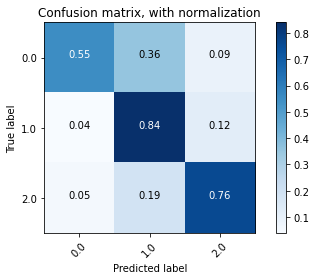

In [44]:
alpha = 0.1 # This is the smoothing parameter for Laplace/Lidstone smoothing
model = naive_bayes.MultinomialNB(alpha=alpha)

model.fit(X_train,y_train)
y_predicted = model.predict(X_test)

print("\nMetrics\n")
recall = metrics.recall_score(y_test,y_predicted,average='macro')
precision = metrics.precision_score(y_test,y_predicted,average='macro')
f1 = metrics.f1_score(y_test,y_predicted,average='macro')
Accur=metrics.accuracy_score(y_test,y_predicted)
B_Accur=metrics.balanced_accuracy_score(y_test,y_predicted)

print(' Recall metric:',recall)
print(' F1 metric:',f1)
print(' Precision metric:',precision)
print(' Accuracy metric:',Accur)
print(' Balanced Accuracy metric:',B_Accur,"\n")
print("**************************************************\n")

cnf_matrix = confusion_matrix(y_test, y_predicted,labels=[0.0, 1.0, 2.0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0.0, 1.0, 2.0],
                      title='Confusion matrix, with normalization')


In [23]:
skfold = model_selection.StratifiedKFold(n_splits=5,random_state=1)

model2 = RandomForestClassifier(n_estimators=100, max_features="auto", n_jobs=-1,class_weight='balanced')
results = model_selection.cross_val_score(model2, Xv,y, cv=skfold,scoring='balanced_accuracy',n_jobs=-1)
print("Balanced Accuracy : ",results.mean())

model2 = RandomForestClassifier(n_estimators=100, max_features="auto", n_jobs=-1,class_weight='balanced')
results = model_selection.cross_val_score(model2, Xv,y, cv=skfold,scoring='accuracy',n_jobs=-1)
print("Accuracy : ",results.mean())


Balanced Accuracy :  0.6976117955180147
Accuracy :  0.787958749414864



Metrics

 Recall metric: 0.7630520314952977
 F1 metric: 0.7784925823594313
 Precision metric: 0.8113851960556596
 Accuracy metric: 0.8157640232108317
 Balanced Accuracy metric: 0.7630520314952977 

**************************************************

Normalized confusion matrix
[[0.58 0.3  0.12]
 [0.01 0.89 0.09]
 [0.03 0.16 0.82]]


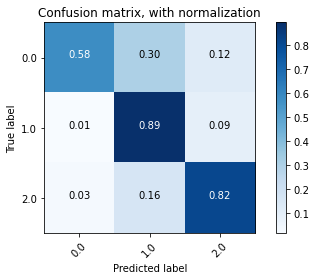

In [45]:
model2 = RandomForestClassifier(n_estimators=100, max_features="auto", n_jobs=-1,class_weight='balanced')
model2.fit(X_train,y_train)
y_predicted = model2.predict(X_test)


recall = metrics.recall_score(y_test,y_predicted,average='macro')
precision = metrics.precision_score(y_test,y_predicted,average='macro')
f1 = metrics.f1_score(y_test,y_predicted,average='macro')
Accur=metrics.accuracy_score(y_test,y_predicted)

print("\nMetrics\n")
recall = metrics.recall_score(y_test,y_predicted,average='macro')
precision = metrics.precision_score(y_test,y_predicted,average='macro')
f1 = metrics.f1_score(y_test,y_predicted,average='macro')
Accur=metrics.accuracy_score(y_test,y_predicted)
B_Accur=metrics.balanced_accuracy_score(y_test,y_predicted)

print(' Recall metric:',recall)
print(' F1 metric:',f1)
print(' Precision metric:',precision)
print(' Accuracy metric:',Accur)
print(' Balanced Accuracy metric:',B_Accur,"\n")
print("**************************************************\n")

cnf_matrix = confusion_matrix(y_test, y_predicted,labels=[0.0, 1.0, 2.0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0.0, 1.0, 2.0],
                      title='Confusion matrix, with normalization')